In [9]:
# Import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5


In [15]:
# Chargement complet
df = pd.read_csv("C:/Users/y.cohen/Desktop/Mémoire/Data/owid-co2-data.csv")

# Variables à garder (excluant population, gdp brut, year, country, iso_code)
selected_vars = [
    'co2_per_capita', 'energy_per_capita', 'cement_co2_per_capita', 'gas_co2_per_capita',
    'oil_co2_per_capita', 'other_co2_per_capita', 'methane_per_capita', 'nitrous_oxide_per_capita',
    'ghg_per_capita', 'land_use_change_co2_per_capita', 'co2_per_gdp', 'energy_per_gdp',
    'co2_including_luc_per_gdp', 'total_ghg', 'cement_co2', 'coal_co2', 'gas_co2', 'oil_co2',
    'other_industry_co2', 'primary_energy_consumption', 'temperature_change_from_ghg',
    'share_of_temperature_change_from_ghg'
]

# Nettoyage : on garde ces colonnes + 'gdp' + 'population' (pour calcul PIB/hab)
df_sel = df[selected_vars + ['gdp', 'population']].dropna()

# Calcul PIB par habitant target
df_sel['gdp_per_capita'] = df_sel['gdp'] / df_sel['population']

# On enlève colonnes non nécessaires
df_sel.drop(columns=['gdp', 'population'], inplace=True)


In [16]:
X = df_sel[selected_vars]
y = df_sel['gdp_per_capita']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling des variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [17]:
# Ridge regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

print(f"Ridge RMSE: {rmse(y_test, y_pred_ridge):.2f}")
print(f"Ridge R²: {r2_score(y_test, y_pred_ridge):.3f}")

# Random Forest (pas besoin de scaler)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(f"Random Forest RMSE: {rmse(y_test, y_pred_rf):.2f}")
print(f"Random Forest R²: {r2_score(y_test, y_pred_rf):.3f}")

# XGBoost (avec données normalisées)
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

print(f"XGBoost RMSE: {rmse(y_test, y_pred_xgb):.2f}")
print(f"XGBoost R²: {r2_score(y_test, y_pred_xgb):.3f}")



Ridge RMSE: 6429.81
Ridge R²: 0.807
Random Forest RMSE: 1106.34
Random Forest R²: 0.994
XGBoost RMSE: 1344.12
XGBoost R²: 0.992


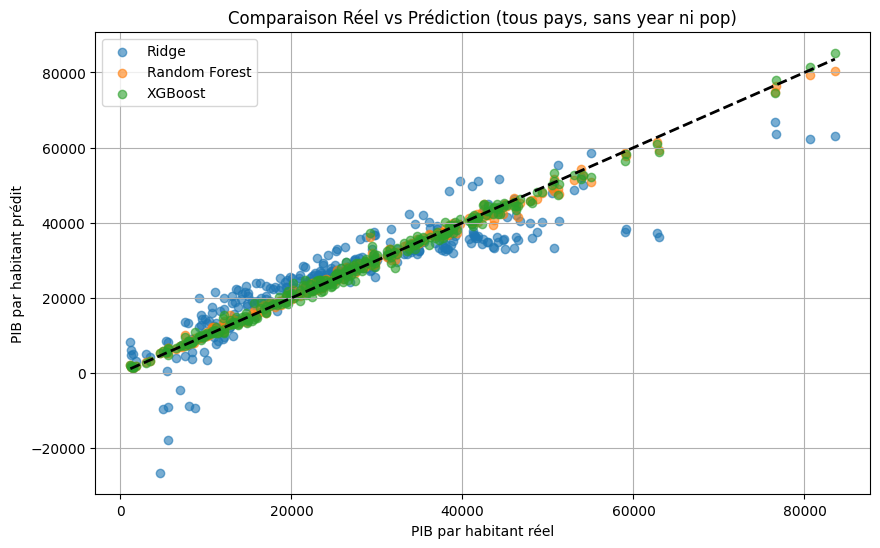

In [18]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_ridge, label='Ridge', alpha=0.6)
plt.scatter(y_test, y_pred_rf, label='Random Forest', alpha=0.6)
plt.scatter(y_test, y_pred_xgb, label='XGBoost', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('PIB par habitant réel')
plt.ylabel('PIB par habitant prédit')
plt.title('Comparaison Réel vs Prédiction (tous pays, sans year ni pop)')
plt.legend()
plt.grid()
plt.show()



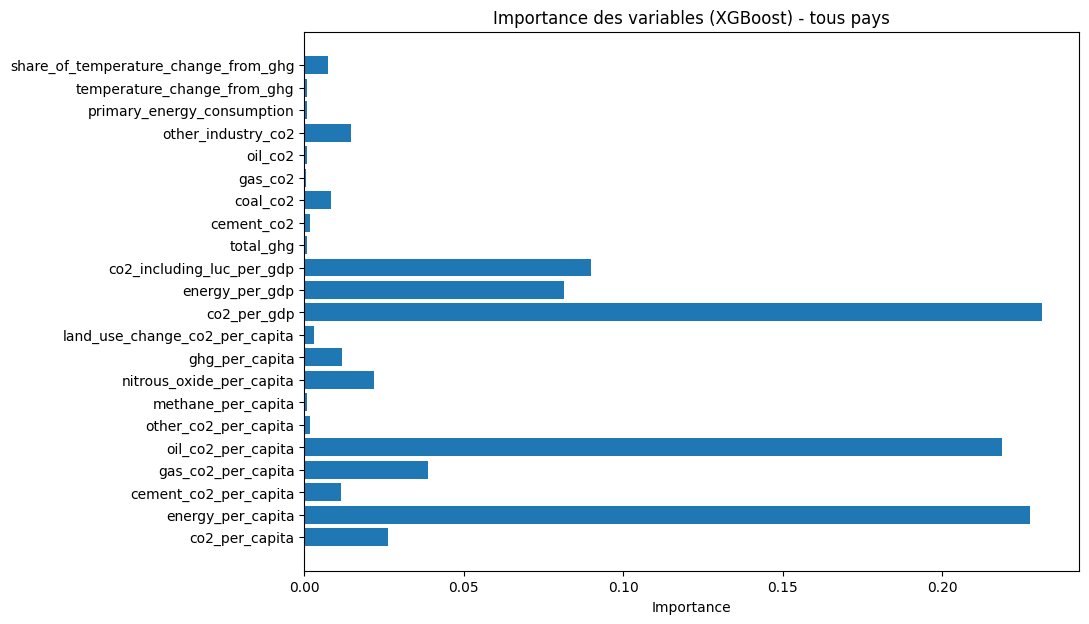

In [19]:
importances = xgb_model.feature_importances_
feat_names = selected_vars

plt.figure(figsize=(10,7))
plt.barh(feat_names, importances)
plt.title("Importance des variables (XGBoost) - tous pays")
plt.xlabel("Importance")
plt.show()


### Comparaison avec la france

In [21]:
# Chargement complet
df = pd.read_csv("C:/Users/y.cohen/Desktop/Mémoire/Data/owid-co2-data.csv")

selected_vars = [
    'co2_per_capita', 'energy_per_capita', 'cement_co2_per_capita', 'gas_co2_per_capita',
    'oil_co2_per_capita', 'other_co2_per_capita', 'methane_per_capita', 'nitrous_oxide_per_capita',
    'ghg_per_capita', 'land_use_change_co2_per_capita', 'co2_per_gdp', 'energy_per_gdp',
    'co2_including_luc_per_gdp', 'total_ghg', 'cement_co2', 'coal_co2', 'gas_co2', 'oil_co2',
    'other_industry_co2', 'primary_energy_consumption', 'temperature_change_from_ghg',
    'share_of_temperature_change_from_ghg'
]

# Dataset global
df_sel = df[selected_vars + ['gdp', 'population']].dropna()
df_sel['gdp_per_capita'] = df_sel['gdp'] / df_sel['population']
df_sel.drop(columns=['gdp', 'population'], inplace=True)

# Dataset France uniquement
df_fr = df[df['country'] == 'France']
df_fr_sel = df_fr[selected_vars + ['gdp', 'population']].dropna()
df_fr_sel['gdp_per_capita'] = df_fr_sel['gdp'] / df_fr_sel['population']
df_fr_sel.drop(columns=['gdp', 'population'], inplace=True)


In [22]:
# Global
X_global = df_sel[selected_vars]
y_global = df_sel['gdp_per_capita']

Xg_train, Xg_test, yg_train, yg_test = train_test_split(X_global, y_global, test_size=0.2, random_state=42)

scaler_global = StandardScaler()
Xg_train_scaled = scaler_global.fit_transform(Xg_train)
Xg_test_scaled = scaler_global.transform(Xg_test)

# France
X_fr = df_fr_sel[selected_vars]
y_fr = df_fr_sel['gdp_per_capita']

Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_fr, y_fr, test_size=0.2, random_state=42)

scaler_fr = StandardScaler()
Xf_train_scaled = scaler_fr.fit_transform(Xf_train)
Xf_test_scaled = scaler_fr.transform(Xf_test)


In [23]:
def train_and_eval(X_train, X_test, y_train, y_test, scaler_used=True):
    # Ridge
    ridge = Ridge(alpha=1.0)
    if scaler_used:
        ridge.fit(X_train, y_train)
        y_pred_ridge = ridge.predict(X_test)
    else:
        ridge.fit(X_train, y_train)
        y_pred_ridge = ridge.predict(X_test)

    # Random Forest (pas de scaling)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train if not scaler_used else scaler.inverse_transform(X_train), y_train)
    y_pred_rf = rf.predict(X_test if not scaler_used else scaler.inverse_transform(X_test))

    # XGBoost
    xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    return (y_pred_ridge, y_pred_rf, y_pred_xgb, ridge, rf, xgb_model)

# Global
y_pred_ridge_g, y_pred_rf_g, y_pred_xgb_g, ridge_g, rf_g, xgb_g = train_and_eval(
    Xg_train_scaled, Xg_test_scaled, yg_train, yg_test, scaler_used=True
)

# France
y_pred_ridge_f, y_pred_rf_f, y_pred_xgb_f, ridge_f, rf_f, xgb_f = train_and_eval(
    Xf_train_scaled, Xf_test_scaled, yf_train, yf_test, scaler_used=True
)

# Évaluation
def print_scores(y_test, y_pred, label):
    print(f"{label} RMSE: {rmse(y_test, y_pred):.2f}")
    print(f"{label} R²: {r2_score(y_test, y_pred):.3f}")

print("=== Global dataset ===")
print_scores(yg_test, y_pred_ridge_g, "Ridge")
print_scores(yg_test, y_pred_rf_g, "Random Forest")
print_scores(yg_test, y_pred_xgb_g, "XGBoost")

print("\n=== France dataset ===")
print_scores(yf_test, y_pred_ridge_f, "Ridge")
print_scores(yf_test, y_pred_rf_f, "Random Forest")
print_scores(yf_test, y_pred_xgb_f, "XGBoost")


=== Global dataset ===
Ridge RMSE: 6429.81
Ridge R²: 0.807
Random Forest RMSE: 1106.34
Random Forest R²: 0.994
XGBoost RMSE: 1344.12
XGBoost R²: 0.992

=== France dataset ===
Ridge RMSE: 315.42
Ridge R²: 0.984
Random Forest RMSE: 597.21
Random Forest R²: 0.944
XGBoost RMSE: 1340.22
XGBoost R²: 0.719


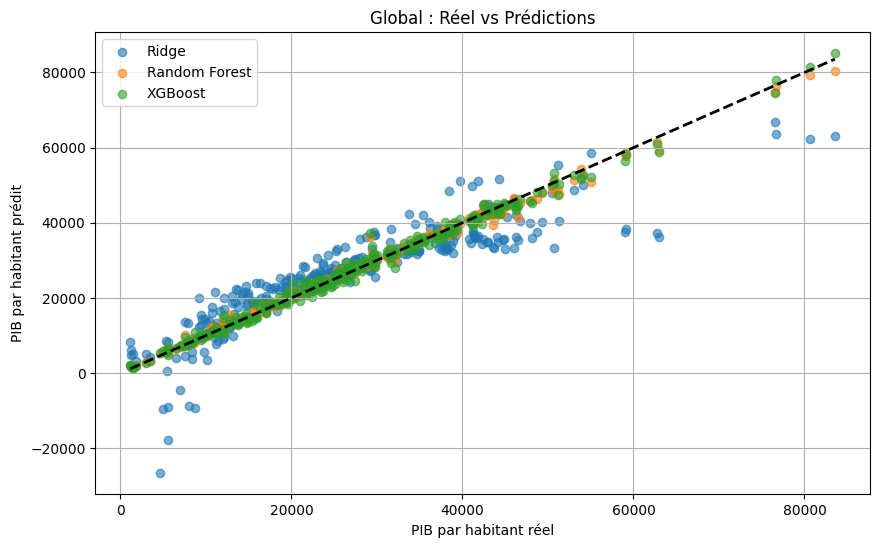

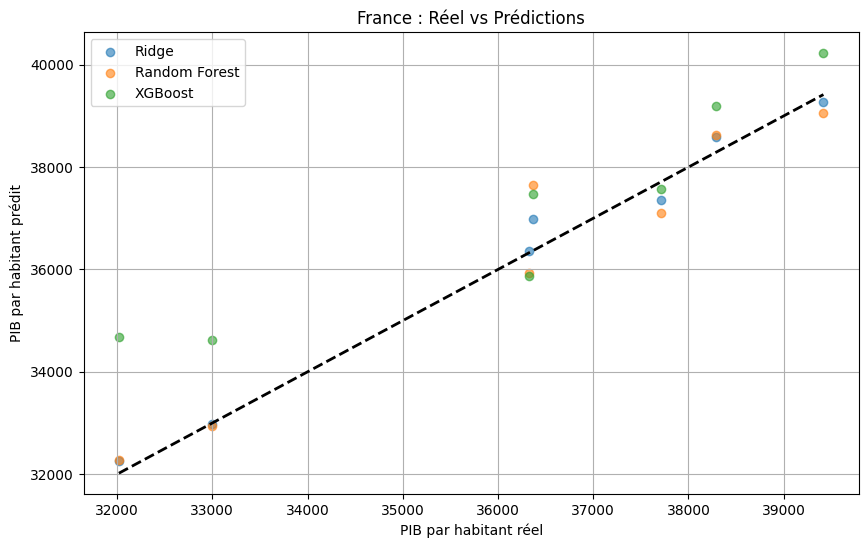

In [24]:
def plot_preds(y_test, preds_dict, title):
    plt.figure(figsize=(10,6))
    plt.scatter(y_test, preds_dict['Ridge'], label='Ridge', alpha=0.6)
    plt.scatter(y_test, preds_dict['Random Forest'], label='Random Forest', alpha=0.6)
    plt.scatter(y_test, preds_dict['XGBoost'], label='XGBoost', alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('PIB par habitant réel')
    plt.ylabel('PIB par habitant prédit')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Global
plot_preds(yg_test, {'Ridge': y_pred_ridge_g, 'Random Forest': y_pred_rf_g, 'XGBoost': y_pred_xgb_g}, "Global : Réel vs Prédictions")

# France
plot_preds(yf_test, {'Ridge': y_pred_ridge_f, 'Random Forest': y_pred_rf_f, 'XGBoost': y_pred_xgb_f}, "France : Réel vs Prédictions")


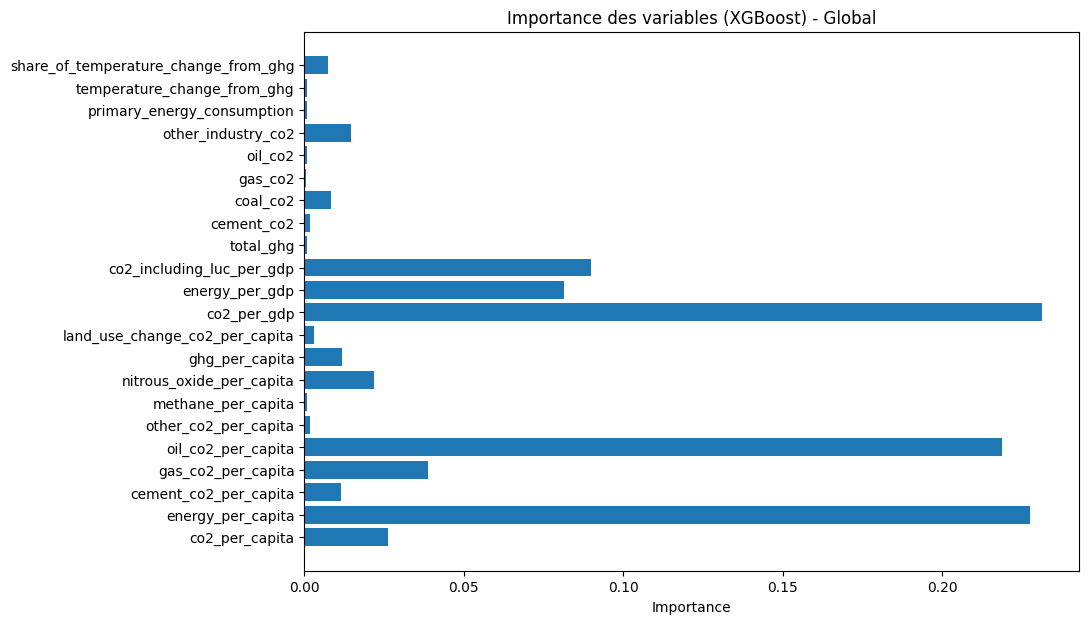

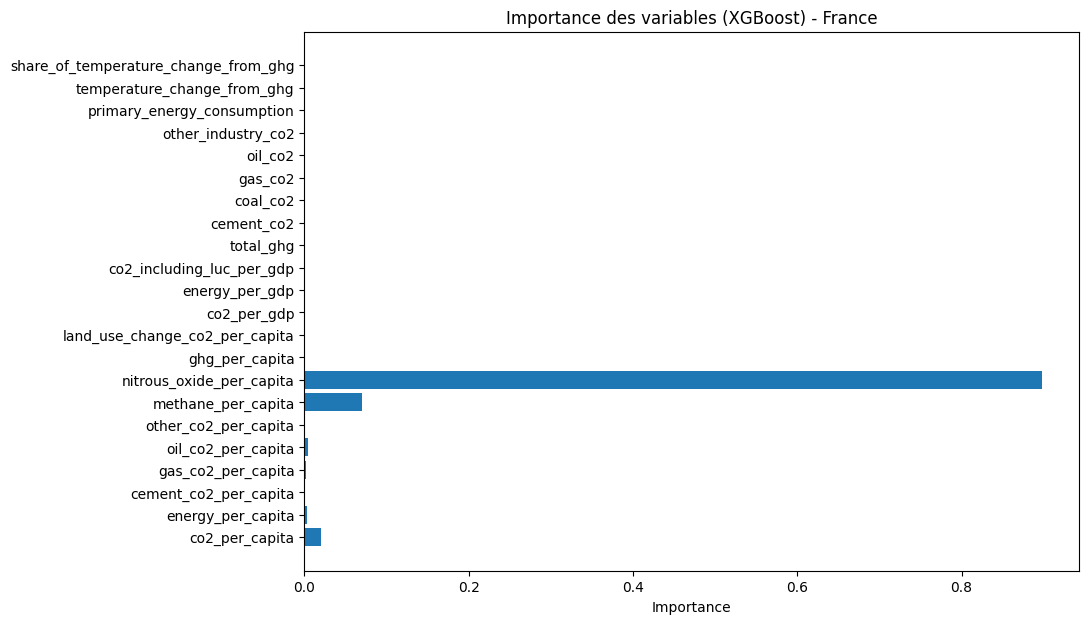

In [25]:
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    plt.figure(figsize=(10,7))
    plt.barh(feature_names, importances)
    plt.title(title)
    plt.xlabel("Importance")
    plt.show()

# Global
plot_feature_importance(xgb_g, selected_vars, "Importance des variables (XGBoost) - Global")

# France
plot_feature_importance(xgb_f, selected_vars, "Importance des variables (XGBoost) - France")
